<a href="https://colab.research.google.com/github/UiinKim/NLP_First/blob/main/2_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

통계기반기법(배치) <-> 추론기반기법(미니배치)
gpu를 사용해서 병렬로 들어감 -> 학습속도 향상



모델이 context 정보를 입력받아 각 단어의 출현 확률을 출력

In [65]:
class MatMul:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)] #grads에 기울기 W보관하기 위해 리스트 선언
        self.x = None

    def forward(self, x):
        W, = self.params
        out = np.matmul(x, W)
        self.x = x
        return out

    def backward(self, dout):
        W, = self.params
        dx = np.matmul(dout, W.T) #x이므로 W.T와 dout
        dW = np.matmul(self.x.T, dout) #W이므로 x.T와 dout
        self.grads[0][...] = dW #역전파가 된 기울기를 grads에 보관
        #생략기호 ...을 활용하여 덮어쓰기 수행 -> 메모리 주소 고정된 자리에 복사(리스트이기 때문에 중요)
        return dx

In [66]:
#원핫벡터 사용
#각 단어 벡터들은 fully connected layer로 연결
import numpy as np

c=np.array([[1, 0, 0, 0, 0, 0, 0]]) #input
W=np.random.randn(7, 3) #weight
h=np.matmul(c, W) #hidden node
print(h)

[[-2.31252292  0.82391062  0.43112278]]


In [67]:
c=np.array([[1, 0, 0, 0, 0, 0, 0]])
W=np.random.randn(7, 3)
layer=MatMul(W)
h=layer.forward(c)
print(h)

[[-1.03265261 -0.99245432  2.02725171]]


In [68]:
#CBOW 모델 추론 과정

c0=np.array([[1,0,0,0,0,0,0]])
c1=np.array([[0,0,1,0,0,0,0]])

W_in=np.random.randn(7, 3)
W_out=np.random.randn(3, 7)

in_layer0=MatMul(W_in) #c0과 가중치 연결
in_layer1=MatMul(W_in) #c1과 가중치 연결
out_layer=MatMul(W_out)

h0=in_layer0.forward(c0)
h1=in_layer1.forward(c1)
h=0.5*(h0+h1)
s=out_layer.forward(h)

print(s)


[[ 0.1310107  -1.30366002  3.19825263 -0.55817108  1.31204891 -0.12905383
  -0.14820495]]


context를 신경망에 넣으면 target이 나오도록

In [69]:
def preprocess(text):
  text=text.lower()
  text=text.replace('.', ' .')
  words=text.split()
  word_to_id={}
  id_to_word={}
  for word in words:
    if word not in word_to_id:
      new_id=len(word_to_id)
      word_to_id[word]=new_id
      id_to_word[new_id]=word

  corpus=np.array([word_to_id[w]for w in words])
  return corpus, word_to_id, id_to_word

In [70]:
text='You say goodbye and I say hello. '
corpus, word_to_id, id_to_word=preprocess(text)

print(corpus)

print(id_to_word)

[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [71]:
#context와 target 만드는 함수
def create_contexts_target(corpus, window_size=1):
  target=corpus[window_size:-window_size] #여기서는 맨 앞 단어와 맨 뒷 단어 제외 windowsize=1이기 때문
  contexts=[]

  for idx in range(window_size, len(corpus)-window_size):#맨 앞과 맨 뒤 단어 제외하고 반복
    cs=[] #context 저장
    for t in range(-window_size, window_size+1): #해당 인덱스의 -1, +1까지 고려
      if t==0: #0일 경우는 target 본인이기 때문에 제외
        continue
      cs.append(corpus[idx+t]) #양 옆의 단어들을 context에 저장
    contexts.append(cs) #context 모음에 해당 context 저장

  return np.array(contexts), np.array(target)

In [72]:
contexts, target=create_contexts_target(corpus)

print(contexts)

print(target)

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]
[1 2 3 4 1 5]


In [73]:
def convert_one_hot(corpus, vocab_size):
  N=corpus.shape[0] #target의 shape을 복사

  if corpus.ndim==1: #target이 1차원인 경우
    one_hot=np.zeros((N, vocab_size), dtype=np.int32)#one-hot으로 만들기 위해 target, vocab_size로 0행렬 생성
    for idx, word_id in enumerate(corpus): #해당 target의 좌표 생성
      one_hot[idx, word_id]=1 #해당 target의 자표에 1 입력하여 one-hot vector 생성

  elif corpus.ndim==2: #target이 2차원인 경우
    C=corpus.shape[1] #target의 다음 차원의 형태를 C에 저장
    one_hot=np.zeros((N, C, vocab_size), dtype= np.int32) #target[0], target[1], vocabsize로 0행렬ㄹ 생성
    for idx_0, word_ids in enumerate(corpus):
      for idx_1, word_id in enumerate(word_ids):
        one_hot[idx_0, idx_1, word_id]=1

  return one_hot

In [74]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
contexts, target = create_contexts_target(corpus, window_size=1)
vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

CBOW 구현

In [75]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    # 정답 데이터가 원핫 벡터일 경우 정답 레이블 인덱스로 변환
    if t.size == y.size:
        t = t.argmax(axis=1)

    batch_size = y.shape[0]

    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

In [76]:
def relu(x):
    return np.maximum(0, x)

def softmax(x):
    if x.ndim == 2:
        x = x - x.max(axis=1, keepdims=True)
        x = np.exp(x)
        x /= x.sum(axis=1, keepdims=True)
    elif x.ndim == 1:
        x = x - np.max(x)
        x = np.exp(x) / np.sum(np.exp(x))

    return x

In [77]:
class Softmax:
    def __init__(self):
        self.params, self.grads = [], []
        self.out = None

    def forward(self, x):
        self.out = softmax(x)
        return self.out

    def backward(self, dout):
        dx = self.out * dout
        sumdx = np.sum(dx, axis=1, keepdims=True)
        dx -= self.out * sumdx
        return dx

In [78]:
class SoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.y = None  # softmax의 출력
        self.t = None  # 정답 레이블

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)

        # 정답 레이블이 원핫 벡터일 경우 정답의 인덱스로 변환
        if self.t.size == self.y.size:
            self.t = self.t.argmax(axis=1)

        loss = cross_entropy_error(self.y, self.t)
        return loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = self.y.copy()
        dx[np.arange(batch_size), self.t] -= 1
        dx *= dout
        dx = dx / batch_size

        return dx

In [79]:
class SimpleCBOW:
  def __init__(self, vocab_size, hidden_size):
    V, H=vocab_size, hidden_size

    #가중치 초기화
    W_in=0.01*np.random.randn(V, H).astype('f') #vocab_size, hidden_size 차원의 난수 생성
    W_out=0.01*np.random.randn(H, V).astype('f') #

    #계층 생성
    self.in_layer0=MatMul(W_in) #연결층1
    self.in_layer1=MatMul(W_in) #연결층2
    self.out_layer=MatMul(W_out) #합해져서 나오는 층
    self.loss_layer=SoftmaxWithLoss() #손실층

    #모든 가중치와 기울기를 리스트에 모은다.
    layers=[self.in_layer0, self.in_layer1, self.out_layer]
    self.params, self.grads=[],[]
    for layer in layers: #모든 층의 각 층마다의 파라미터와 기울기를 저장
      self.params+=layer.params
      self.grads+=layer.grads

    #인스턴스 변수에 단어의 분산 표현을 저장
    self.word_vecs=W_in

  def forward(self, contexts, target):
    h0=self.in_layer0.forward(contexts[:,0])
    h1=self.in_layer1.forward(contexts[:,1])
    h=(h0+h1)*0.5
    score=self.out_layer.forward(h)
    loss=self.loss_layer.forward(score, target)
    return loss

  def backward(self, dout=1):
    ds=self.loss_layer.backward(dout)
    da=self.out_layer.backward(ds)
    da*=0.5
    self.in_layer1.backward(da)
    self.in_layer0.backward(da)
    return None



In [80]:
import time
import matplotlib.pyplot as plt

def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)

    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate

In [81]:
class Trainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.loss_list = []
        self.eval_interval = None
        self.current_epoch = 0

    def fit(self, x, t, max_epoch=10, batch_size=32, max_grad=None, eval_interval=20):
        data_size = len(x)
        max_iters = data_size // batch_size
        self.eval_interval = eval_interval
        model, optimizer = self.model, self.optimizer
        total_loss = 0
        loss_count = 0

        start_time = time.time()
        for epoch in range(max_epoch):
            # 뒤섞기
            idx = np.random.permutation(np.arange(data_size))
            x = x[idx]
            t = t[idx]

            for iters in range(max_iters):
                batch_x = x[iters*batch_size:(iters+1)*batch_size]
                batch_t = t[iters*batch_size:(iters+1)*batch_size]

                # 기울기 구해 매개변수 갱신
                loss = model.forward(batch_x, batch_t)
                model.backward()
                params, grads = remove_duplicate(model.params, model.grads)  # 공유된 가중치를 하나로 모음
                if max_grad is not None:
                    clip_grads(grads, max_grad)
                optimizer.update(params, grads)
                total_loss += loss
                loss_count += 1

                # 평가
                if (eval_interval is not None) and (iters % eval_interval) == 0:
                    avg_loss = total_loss / loss_count
                    elapsed_time = time.time() - start_time
                    print('| 에폭 %d |  반복 %d / %d | 시간 %d[s] | 손실 %.2f'
                          % (self.current_epoch + 1, iters + 1, max_iters, elapsed_time, avg_loss))
                    self.loss_list.append(float(avg_loss))
                    total_loss, loss_count = 0, 0

            self.current_epoch += 1

    def plot(self, ylim=None):
        x = np.arange(len(self.loss_list))
        if ylim is not None:
            plt.ylim(*ylim)
        plt.plot(x, self.loss_list, label='train')
        plt.xlabel('반복 (x' + str(self.eval_interval) + ')')
        plt.ylabel('손실')
        plt.show()


class RnnlmTrainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.time_idx = None
        self.ppl_list = None
        self.eval_interval = None
        self.current_epoch = 0

    def get_batch(self, x, t, batch_size, time_size):
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')

        data_size = len(x)
        jump = data_size // batch_size
        offsets = [i * jump for i in range(batch_size)]  # 배치에서 각 샘플을 읽기 시작하는 위치

        for time in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, time] = x[(offset + self.time_idx) % data_size]
                batch_t[i, time] = t[(offset + self.time_idx) % data_size]
            self.time_idx += 1
        return batch_x, batch_t

    def fit(self, xs, ts, max_epoch=10, batch_size=20, time_size=35,
            max_grad=None, eval_interval=20):
        data_size = len(xs)
        max_iters = data_size // (batch_size * time_size)
        self.time_idx = 0
        self.ppl_list = []
        self.eval_interval = eval_interval
        model, optimizer = self.model, self.optimizer
        total_loss = 0
        loss_count = 0

        start_time = time.time()
        for epoch in range(max_epoch):
            for iters in range(max_iters):
                batch_x, batch_t = self.get_batch(xs, ts, batch_size, time_size)

                # 기울기를 구해 매개변수 갱신
                loss = model.forward(batch_x, batch_t)
                model.backward()
                params, grads = remove_duplicate(model.params, model.grads)  # 공유된 가중치를 하나로 모음
                if max_grad is not None:
                    clip_grads(grads, max_grad)
                optimizer.update(params, grads)
                total_loss += loss
                loss_count += 1

                # 퍼플렉서티 평가
                if (eval_interval is not None) and (iters % eval_interval) == 0:
                    ppl = np.exp(total_loss / loss_count)
                    elapsed_time = time.time() - start_time
                    print('| 에폭 %d |  반복 %d / %d | 시간 %d[s] | 퍼플렉서티 %.2f'
                          % (self.current_epoch + 1, iters + 1, max_iters, elapsed_time, ppl))
                    self.ppl_list.append(float(ppl))
                    total_loss, loss_count = 0, 0

            self.current_epoch += 1

    def plot(self, ylim=None):
        x = np.arange(len(self.ppl_list))
        if ylim is not None:
            plt.ylim(*ylim)
        plt.plot(x, self.ppl_list, label='train')
        plt.xlabel('반복 (x' + str(self.eval_interval) + ')')
        plt.ylabel('퍼플렉서티')
        plt.show()


def remove_duplicate(params, grads):
    '''
    매개변수 배열 중 중복되는 가중치를 하나로 모아
    그 가중치에 대응하는 기울기를 더한다.
    '''
    params, grads = params[:], grads[:]  # copy list

    while True:
        find_flg = False
        L = len(params)

        for i in range(0, L - 1):
            for j in range(i + 1, L):
                # 가중치 공유 시
                if params[i] is params[j]:
                    grads[i] += grads[j]  # 경사를 더함
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)
                # 가중치를 전치행렬로 공유하는 경우(weight tying)
                elif params[i].ndim == 2 and params[j].ndim == 2 and \
                     params[i].T.shape == params[j].shape and np.all(params[i].T == params[j]):
                    grads[i] += grads[j].T
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)

                if find_flg: break
            if find_flg: break

        if not find_flg: break

    return params, grads

In [82]:
class Adam:
    '''
    Adam (http://arxiv.org/abs/1412.6980v8)
    '''
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None

    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = [], []
            for param in params:
                self.m.append(np.zeros_like(param))
                self.v.append(np.zeros_like(param))

        self.iter += 1
        lr_t = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)

        for i in range(len(params)):
            self.m[i] += (1 - self.beta1) * (grads[i] - self.m[i])
            self.v[i] += (1 - self.beta2) * (grads[i]**2 - self.v[i])

            params[i] -= lr_t * self.m[i] / (np.sqrt(self.v[i]) + 1e-7)

| 에폭 1 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 2 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 3 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 4 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 5 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 6 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 7 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 8 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 9 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 10 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 11 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 12 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 13 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 14 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 15 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 16 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 17 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 18 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 19 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 20 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 21 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 22 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 23 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 24 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 25 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 26 |

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49552 (\N{HANGUL SYLLABLE SON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


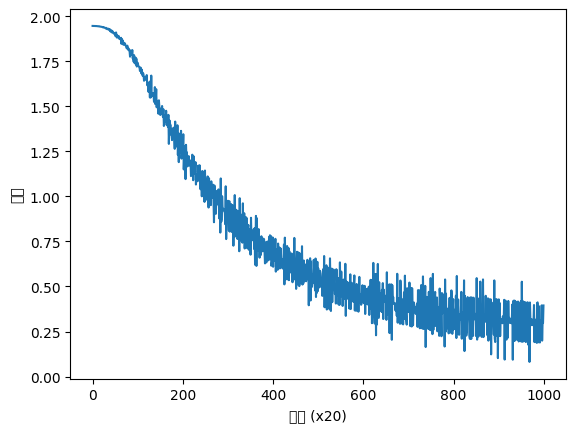

In [83]:
window_size=1 #context=2
hidden_size=5
batch_size=3
max_epoch=1000

text='You say goodbye and I say hello.'
corpus, word_to_id, id_to_word=preprocess(text) #단어 사전과 숫자로 바뀐 text 가져오기

vocab_size=len(word_to_id)
contexts, target=create_contexts_target(corpus, window_size) #corpus의 contexts(주변 단어)와 target(해당 단어)을 설정
target=convert_one_hot(target, vocab_size) #target을 원핫벡터로 변경
contexts=convert_one_hot(contexts, vocab_size) #contexts를 원핫벡터로 변경

model=SimpleCBOW(vocab_size, hidden_size) #model에 input size와 hiddensize 설정하여 입력
optimizer=Adam() #최적화는 adam사용
trainer=Trainer(model, optimizer) #모델 설정

trainer.fit(contexts, target, max_epoch, batch_size) #모델 훈련
trainer.plot()

In [84]:
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
  print(word, word_vecs[word_id])

you [-1.7574403   1.0431722  -0.99750024 -0.99726194 -0.9789928 ]
say [-1.1137519  -0.15420389  1.2349337   0.44597363  1.2410873 ]
goodbye [ 0.9009335  0.9522987 -0.8961247 -0.9531979 -0.8970199]
and [-0.82168025  1.6880766   1.0462081   1.5320684   1.0214111 ]
i [ 0.89225197  0.9412085  -0.9054221  -0.9412592  -0.88208777]
hello [-1.7634475  1.0290056 -0.9951582 -1.0114313 -0.9848277]
. [-1.064954  -1.3936609  1.1043482 -1.5834507  1.1078029]
